Assignment 5: 

Name: Sumedh Koppula

UID: 117386066

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: Sumedh Reddy Koppula 

In [1]:
# import the necessary packages
import numpy as np
import gzip, os
from urllib.request import urlretrieve
from random import random
from math import exp
from random import seed
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Part 1: Backpropagation in Neural Networks (20 Points)

#### Overview
Artificial Neural Networks are computational learning systems that uses a network of functions to understand and translate a data train_features of one form into a desired output, usually in another form. The concept of the artificial neural network was inspired by human biology and the way neurons of the human brain function together to understand inputs from human senses.

A simple neural network consists of train_features Layer, Hidden Layer and Output Layer.
To train these the network, we will use Backpropagation algorithm.  Backpropagation is the cornerstone of modern neural networks. To understand the algorithm in details, here is a mathematical description in the Chapter 2 of *How the backpropagation algorithm works from Neural Networks and Deep Learning* (http://neuralnetworksanddeeplearning.com/chap2.html).

In this part, you are required to implement the following architecture and write training code of a neural network from scratch using the numpy library alone. 

Architecture Definition :

*   An train_features Layer with the following 2-dimensions:
  *  0: Batch Size
  *  1: 784 = 28*28 pixels
* A hidden layer with 500 units
* A second hidden layer with 50 units
* An output layer with 10 units

There are five major steps to the implementation:

1. Define neural network: initialize_network()

2. Forward Propagation: pre_activation(), sigmoid_activation(), forward_propagation()

3. Backpropagation: backward_propagate_error()

4. Loss function and updation of weights_vector (SGD): update_weights_vector()

5. Training: train()


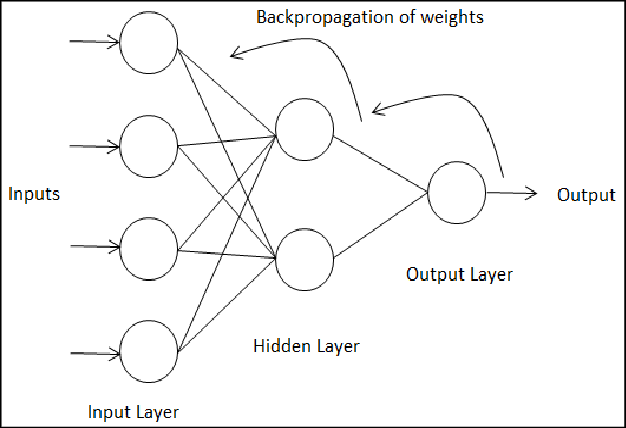



## Data

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 11SpETIc56PReKuaUKEwWDvdkiynyyGFA
!unzip "/content/MNISTArchive.zip" -d "/content/"
!gzip -d "/content/t10k-labels-idx1-ubyte.gz"
!gzip -d "/content/t10k-images-idx3-ubyte.gz" 
!gzip -d "/content/train-labels-idx1-ubyte.gz"
!gzip -d "/content/train-images-idx3-ubyte.gz"

## Helper Functions:

### Code (10 pts)

In [2]:
def read_mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\mnist
        path = os.path.join(os.path.expanduser('~'), 'data', 'mnist')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))

    return train_images, train_labels, test_images, test_labels

In [13]:
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()

	## Write your code. Initialize hidden layer here.
	hidden_layer = [{'weights_vector':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	network.append(hidden_layer)

	## Write your code. Initialize output_layer layer here.
	output_layer = [{'weights_vector':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network

def initialize_network_mnist(train_data, y, n_hidden, neuron_size, n_inputs= None, n_outputs= None):
	if n_inputs is not None:
		input_value = n_inputs
	else:
		input_value = train_features.shape[1]
	if n_outputs is not None:
		output_value = n_outputs
	else:
		output_value = y.shape[1]
	biases = []
	weights_vector = []
	weights_vector.append(np.random.randn(input_value, neuron_size[0]) * np.sqrt(0.006))
	for i in range(n_hidden):
		weights_vector.append(np.random.randn(weights_vector[i].shape[1], neuron_size[i + 1]) * np.sqrt(0.006))

	weights_vector.append(np.random.randn(weights_vector[-1].shape[1], output_value) * np.sqrt(0.006))

	for i in range(len(weights_vector)):
		biases.append(np.random.randn(weights_vector[i].shape[1], ) * np.sqrt(0.006))

	return weights_vector, biases

In [28]:
# Calculate neuron activation for an train_features
def pre_activation(weights_vector, inputs):
	activation = weights_vector[-1]
	for i in range(len(weights_vector)-1):
		## Write code here. compute activation: Wx+b
		activation += weights_vector[i] * inputs[i]
	
	return activation

def sigmoid_activation(activation):
	## write code. implement sigmoid function
	out_sigmoid = 1.0 / (1.0 + exp(-activation))
	return out_sigmoid
 
# Calculate the derivative of a neuron output
def sigmoid_derivative(output):
	## write code. implement sigmoid function
	out_sigmoid_deriv = output * (1.0 - output)
	return out_sigmoid_deriv

# Relu activation function
def ReLU(x):
	relu_ = np.maximum(0, x)
	return relu_

# Relu derivative function
def dReLU(x):
	relu_derivative = 1 * (x > 0)
	return relu_derivative

# Softmax activation function
def softmax(z):
	z = z - np.max(z, axis=1).reshape(z.shape[0], 1)
	softmax_ = np.exp(z) / np.sum(np.exp(z), axis=1).reshape(z.shape[0], 1) 
	return softmax_

# Shuffle the train_features and expected
def shuffle(train_features, expected):
    idx = [i for i in range(train_features.shape[0])]
    np.random.shuffle(idx)
    train_features = train_features[idx]
    expected = expected[idx]
    return train_features, expected

# Reverse the list
def reverse_list(sample_list):
    reversed_list = sample_list.copy()
    reversed_list.reverse()
    return reversed_list

In [36]:
# Forward Propagation:
def forward_propagation(network, row):
	inputs = row
	for layer in network:

		new_inputs = []
		## write you code here.
		## for each hidden neuron this 'layer', compute \
		## pre_activation, sigmoid_activation and save then output in 'new_inputs.'
		for neuron in layer:
			activation = pre_activation(neuron['weights_vector'], inputs)
			neuron['output'] = sigmoid_activation(activation)
			new_inputs.append(neuron['output'])

		inputs = new_inputs
	return inputs

# Backpropagation:
def backward_propagate_error(network, ground_truth):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			## write your code here.
			## compute error for all the hidden layer and append it to errors to keep track.
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights_vector'][j] * neuron['delta'])
				errors.append(error)
			#print("error computed for hidden layer")
		else:
			## write your code here.
			## compute error for the output layer using ground_truth and append it to errors to keep track.
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(ground_truth[j] - neuron['output'])
					
			#print("error computed for output layer")
	 
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * sigmoid_derivative(neuron['output'])
			#print("delta computed for neuron")

   
# Stochastic GD for weight updation:
def update_weights_vector(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			## write your code here.
			## pass activation i.e. neuron['output'] from previous layer as train_features to current layer 'i'
			inputs = [neuron['output'] for neuron in network[i - 1]]
			#print("train_features computed for hidden layer")
	 
		for neuron in network[i]:						
			for j in range(len(inputs)):
				## write you code here.
				## update the weights_vector between each train_features and each neuron.
				# Handle index out of range error
				if j < len(neuron['weights_vector']):
					neuron['weights_vector'][j] += l_rate * neuron['delta'] * inputs[j]
	
			## write you code here.
			## update the bias vector
			neuron['weights_vector'][-1] += l_rate * neuron['delta']
			#print("bias updated")
	 
# Train a network for a fixed number of epochs
def train(network, train, l_rate, n_epoch, n_outputs):
	sum_error_lst = []
	for epoch in range(n_epoch):
		sum_error = 0
		for row in train:
			outputs = forward_propagation(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[int(row[-1])] = 1
			#expected[row[-1]] = 1
			sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
			backward_propagate_error(network, expected)
			update_weights_vector(network, row, l_rate)
		sum_error_lst.append(sum_error)
		print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))

	return sum_error_lst

# Feed forward for MNIST dataset
def feed_forward_mnist(x_, y_, weights_vector, bias_vector):
	layer_output_ = []
	activation_layer_ = []

	assert x_.shape[1] == weights_vector[0].shape[0]
	layer_output_.append(x_.dot(weights_vector[0]) + bias_vector[0])
	activation_layer_.append(ReLU(layer_output_[0]))

	for i in range(1, len(weights_vector)):
		assert activation_layer_[i - 1].shape[1] == weights_vector[i].shape[0]
		layer_output_.append(activation_layer_[i - 1].dot(weights_vector[i]) + bias_vector[i])
		activation_layer_.append(ReLU(layer_output_[i]))

	error = activation_layer_[-1] - y_
	return error, activation_layer_, layer_output_, weights_vector, bias_vector, x_, y_

# Backpropagation for MNIST dataset
def back_propagation_mnist(activation_layer_, layer_output_, weights_vector, bias_vector, batch, error, learning_rate, x):
	d_cost = (1 / batch) * error
	values = []
	b_values = []
	delete_weights = []
	delete_bias = []
	reverse_relu_activation = reverse_list(activation_layer_)
	reverse_relu_layer = reverse_list(layer_output_)
	reverse_weights = reverse_list(weights_vector)
	reverse_bias = reverse_list(bias_vector)
	delete_weights.append(np.dot(d_cost.T, reverse_relu_activation[1]).T)
	val = np.dot((d_cost), reverse_weights[0].T) * dReLU(reverse_relu_layer[1])
	values.append(val)
	delete_weights.append((np.dot(val.T, reverse_relu_activation[2])).T)

	for i in range(len(weights_vector) - 3):
		val = np.dot(values[i], reverse_weights[i + 1].T) * dReLU(reverse_relu_layer[i + 2])
		values.append(val)
		delete_weights.append((np.dot(values[i + 1].T, reverse_relu_activation[i + 3])).T)

	delete_weights.append(np.dot((np.dot(values[-1], reverse_weights[-2].T) * dReLU(reverse_relu_layer[-1])).T, x).T)

	delete_bias.append(np.sum(d_cost, axis=0))

	b_val = np.dot((d_cost), reverse_weights[0].T) * dReLU(reverse_relu_layer[1])
	b_values.append(b_val)
	delete_bias.append(np.sum(b_val, axis=0))

	for i in range(len(weights_vector) - 2):
		b_val = np.dot(b_values[i], reverse_weights[i + 1].T) * dReLU(reverse_relu_layer[i + 2])
		b_values.append(b_val)
		delete_bias.append(np.sum(b_values[i + 1], axis=0))

	for i in range(len(weights_vector)):
		assert delete_weights[i].shape == reverse_weights[i].shape
		reverse_weights[i] = reverse_weights[i] - learning_rate * delete_weights[i]
		assert delete_bias[i].shape == reverse_bias[i].shape
		reverse_bias[i] = reverse_bias[i] - learning_rate * delete_bias[i]

	reverse_weights.reverse()
	reverse_bias.reverse()

	return reverse_weights, reverse_bias

def train_mnist(train_features, expected, weights_vector, biases, batch_size, epochs, learning_rate):
    loss_list = []
    accuracy_list = []
    for j in range(epochs):
        l = 0
        accuracy_value = 0
        train_features, expected = shuffle(train_features, expected)

        for i in range(train_features.shape[0] // batch_size - 1):
            start = i * batch_size
            end = (i + 1) * batch_size
            x = train_features[start:end]
            y = expected[start:end]
            error, activation_layer, layer_output, weights_vector, biases, x, y = feed_forward_mnist(x, y, weights_vector, biases)
            weights_vector, biases = back_propagation_mnist(activation_layer, layer_output, weights_vector, biases, batch_size, error, learning_rate, x)
            l += np.mean(error ** 2)
            accuracy_value += np.count_nonzero(np.argmax(activation_layer[-1], axis=1) == np.argmax(y, axis=1)) / batch_size

        loss_list.append(l / (train_features.shape[0] // batch_size))
        accuracy_list.append(accuracy_value / (train_features.shape[0] // batch_size))
    print("Train Accuracy:", np.max(accuracy_list) * 100, "%")
    return weights_vector, biases, loss_list, accuracy_list


def test_mnist(xtest, ytest, weights_vector, biases):
    x = xtest
    y = ytest
    _, activation_layer, _, weights_vector, biases, x, y = feed_forward_mnist(x, y, weights_vector, biases)
    accuracy_val = np.count_nonzero(np.argmax(activation_layer[-1], axis=1) == np.argmax(ytest, axis=1)) / xtest.shape[0]
    print("Test Accuracy:", 100 * accuracy_val, "%")

>epoch=0, lrate=0.500, error=6.504
>epoch=1, lrate=0.500, error=5.657
>epoch=2, lrate=0.500, error=5.269
>epoch=3, lrate=0.500, error=4.998
>epoch=4, lrate=0.500, error=4.741
>epoch=5, lrate=0.500, error=4.481
>epoch=6, lrate=0.500, error=4.190
>epoch=7, lrate=0.500, error=3.876
>epoch=8, lrate=0.500, error=3.557
>epoch=9, lrate=0.500, error=3.245
>epoch=10, lrate=0.500, error=2.951
>epoch=11, lrate=0.500, error=2.680
>epoch=12, lrate=0.500, error=2.433
>epoch=13, lrate=0.500, error=2.211
>epoch=14, lrate=0.500, error=2.012
>epoch=15, lrate=0.500, error=1.836
>epoch=16, lrate=0.500, error=1.679
>epoch=17, lrate=0.500, error=1.541
>epoch=18, lrate=0.500, error=1.418
>epoch=19, lrate=0.500, error=1.309
>epoch=20, lrate=0.500, error=1.212
>epoch=21, lrate=0.500, error=1.126
>epoch=22, lrate=0.500, error=1.050
>epoch=23, lrate=0.500, error=0.981
>epoch=24, lrate=0.500, error=0.920
>epoch=25, lrate=0.500, error=0.864
>epoch=26, lrate=0.500, error=0.814
>epoch=27, lrate=0.500, error=0.769
>e

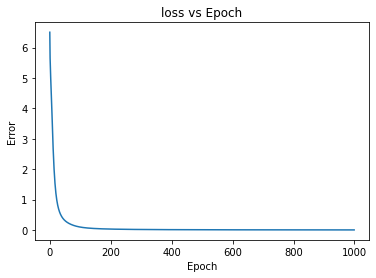

In [34]:
# 1. Test your code for backprop algorithm on this sample dataset.
sample_dataset = [[2.7810836,2.550537003,0],
	[1.465489372,2.362125076,0],
	[3.396561688,4.400293529,0],
	[1.38807019,1.850220317,0],
	[3.06407232,3.005305973,0],
	[7.627531214,2.759262235,1],
	[5.332441248,2.088626775,1],
	[6.922596716,1.77106367,1],
	[8.675418651,-0.242068655,1],
	[7.673756466,3.508563011,1]]

n_inputs = len(sample_dataset[0]) - 1
n_outputs = len(set([sample[-1] for sample in sample_dataset]))
network = initialize_network(n_inputs, 2, n_outputs)
error = train(network, sample_dataset, l_rate=0.5, n_epoch=1000, n_outputs=n_outputs)
for layer in network:
	print(layer)

# Plot error vs epoch
plt.plot(error)
plt.title('loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()


In [40]:
def visualize_loss_epochs(val, ylab):
    plt.plot(val)
    plt.xlabel("Epochs")
    plt.ylabel(ylab)
    plt.title(ylab + ' vs Epochs')
    plt.show()

# Read MNIST data
train_images, train_labels, test_images, test_labels = read_mnist(path='/home/sumedh/Desktop/CMSC_733_HW5/MNISTArchive')

# train_features and expected output
train_features = train_images
train_labels_ = train_labels

# Hyperparameters
batch = 64
learning_rate = 1e-3
epochs = 100

# Train and test
x = train_features[:batch]
y = train_labels_[:batch]

# Initialize weights and biases
weights_vector, biases = initialize_network_mnist(train_features, y, 2, [1000, 500, 50])


Train Accuracy: 95.95951173959445 %
Test Accuracy: 95.39 %


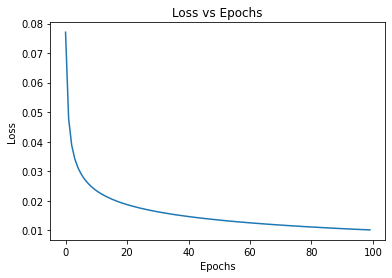

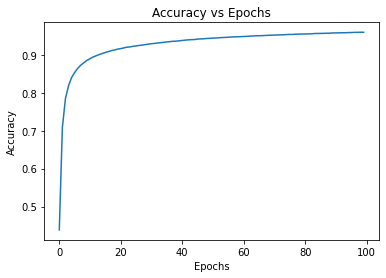

In [37]:

# Train and test
weights_vector, biases, loss, accuracy = train_mnist(train_features, train_labels_, weights_vector, biases, batch, epochs, learning_rate)
test_mnist(test_images, test_labels, weights_vector, biases)

# Visualize loss and accuracy
visualize_loss_epochs(loss, 'Loss')
visualize_loss_epochs(accuracy, 'Accuracy')


### Write-up (10 pts)

1. You are required to report a) train error w.r.t epoch, b) train and test accuracy numbers on MNIST dataset at the end of training.
2. Experiment with different number of a) hidden layers b) training epochs and report the ablation study.

### 1. You are required to report a) train error w.r.t epoch, b) train and test accuracy numbers on MNIST dataset at the end of training.

#### a. Please see the above plots for train error w.r.t epochs AKA Loss vs Epochs 
#### b. Train and Test accuracy numbers on MNIST dataset at the end of training: 
        Train Accuracy MNIST dataset: 95.96 % 
        Test Accuracy MNIST dataset: 95.39 %

### 2. Experiment with different number of a) hidden layers b) training epochs and report the ablation study.

Train Accuracy: 97.05176093916755 %


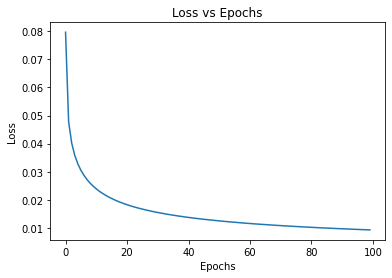

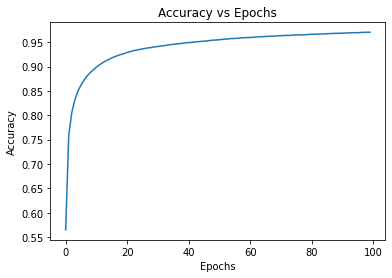

In [41]:
# Experiment 1 - Varying number of hidden layers

# 1 hidden layer
weights_vector, biases = initialize_network_mnist(train_features, y, 1, [1000, 500, 50])
weights_vector, biases, loss, accuracy = train_mnist(train_features, train_labels_, weights_vector, biases, batch, epochs, learning_rate)
visualize_loss_epochs(loss, 'Loss')
visualize_loss_epochs(accuracy, 'Accuracy')


In [43]:
test_mnist(test_images, test_labels, weights_vector, biases)

Test Accuracy: 94.13 %


Train Accuracy: 94.3920090715048 %


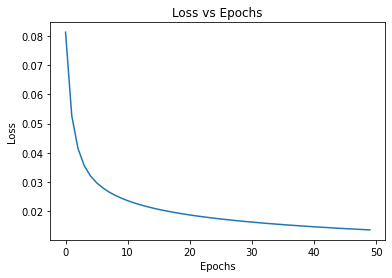

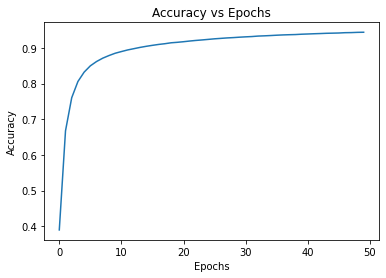

In [42]:
# Different number of epochs
epochs = 50
weights_vector, biases = initialize_network_mnist(train_features, y, 2, [1000, 500, 50])
weights_vector, biases, loss, accuracy = train_mnist(train_features, train_labels_, weights_vector, biases, batch, epochs, learning_rate)
visualize_loss_epochs(loss, 'Loss')
visualize_loss_epochs(accuracy, 'Accuracy')

In [44]:
test_mnist(test_images, test_labels, weights_vector, biases)

Test Accuracy: 94.13 %


Abalation Study:

- More the Dense the network and the Epochs, more is the accuracy of the model

# Part 2: Training an Image Classifier




##Overview
CIFAR10 dataset will be used to train an image classifier.

![](https://miro.medium.com/max/578/1*BCsHErqOJxmKDLQXYJR_ow.png)



##Data
Using `torchvision`, it’s extremely easy to load `CIFAR10`.

In [55]:
## The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


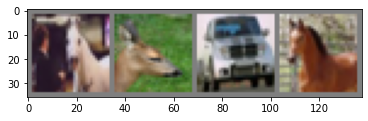

horse deer  car   horse


In [56]:
## Let us show some of the training images, for fun.

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

##Code (20 pts)

###Define a Convolutional Neural Network (10 pt)

Create a neural network that take 3-channel images. It should go as Conv2d --> ReLU --> MaxPool2d --> Conv2d --> ReLU --> MaxPool2d --> Flatten --> Linear --> ReLU --> Linear --> ReLU --> Linear

In [59]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ## TODO: Add layers to your neural net
        # Create a neural network that take 3-channel images
        # It should go as Conv2d --> ReLU --> MaxPool2d --> Conv2d --> ReLU --> MaxPool2d --> Flatten --> Linear --> ReLU --> Linear --> ReLU --> Linear
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,16,3,padding=1)
        self.dp= nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(16 * 8 * 8,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,16)
        self.fc5 = nn.Linear(16,10)



    def forward(self, x):
        ## TODO: run forward pass as mentioned above.
        # Conv2d --> ReLU --> MaxPool2d --> Conv2d --> ReLU --> MaxPool2d --> Flatten --> Linear --> ReLU --> Linear --> ReLU --> Linear
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x=  self.dp(x)
        x = x.view(-1,16 * 8 * 8)
        # increase the number of neurons in the hidden layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        
        return x


net = Net()

###Define a Loss function and optimizer (5 pt)

Let’s use a Classification Cross-Entropy loss and SGD with momentum. (Feel free to experiment with other loss functions and optimizers to observe differences)

In [60]:
# Let’s use a Classification Cross-Entropy loss and SGD with momentum. (Feel free to experiment with other loss functions and optimizers to observe differences)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), learning_rate=0.001, momentum=0.9)

###Train the network (5 pts)

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [61]:
epochs = 10 ## define number of epochs to train

epoch_loss = {}
train_losses = []
train_accuracy = []
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct_values = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
      
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # TODO: add line to zero the parameter gradients below
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        total += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        correct_values += (predictions == labels).float().sum()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    train_accuracy.append((100 * correct_values) / total)
    train_losses.append(running_loss/(i+1))

    # print(f'Accuracy for{epoch}: {(100 * correct_values) / total}')
print('Finished Training')

## Let’s quickly save our trained model:

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 2.304
[1,  4000] loss: 2.284
[1,  6000] loss: 2.064
[1,  8000] loss: 1.861
[1, 10000] loss: 1.747
[1, 12000] loss: 1.655
[2,  2000] loss: 1.531
[2,  4000] loss: 1.471
[2,  6000] loss: 1.428
[2,  8000] loss: 1.378
[2, 10000] loss: 1.354
[2, 12000] loss: 1.305
[3,  2000] loss: 1.255
[3,  4000] loss: 1.212
[3,  6000] loss: 1.210
[3,  8000] loss: 1.179
[3, 10000] loss: 1.180
[3, 12000] loss: 1.181
[4,  2000] loss: 1.094
[4,  4000] loss: 1.101
[4,  6000] loss: 1.090
[4,  8000] loss: 1.057
[4, 10000] loss: 1.055
[4, 12000] loss: 1.067
[5,  2000] loss: 0.988
[5,  4000] loss: 0.985
[5,  6000] loss: 0.989
[5,  8000] loss: 1.002
[5, 10000] loss: 0.965
[5, 12000] loss: 0.978
[6,  2000] loss: 0.907
[6,  4000] loss: 0.925
[6,  6000] loss: 0.927
[6,  8000] loss: 0.928
[6, 10000] loss: 0.931
[6, 12000] loss: 0.917
[7,  2000] loss: 0.842
[7,  4000] loss: 0.885
[7,  6000] loss: 0.860
[7,  8000] loss: 0.896
[7, 10000] loss: 0.866
[7, 12000] loss: 0.859
[8,  2000] loss: 0.800
[8,  4000] 

###Test the network on the test data
We have trained the network over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.


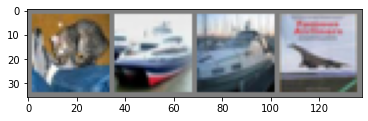

GroundTruth:  cat   ship  ship  plane


In [62]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [63]:
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  plane ship 


In [64]:
# prepare to count predictions for each class
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')



Accuracy of the network on the 10000 test images: 68 %
Accuracy for class: plane is 76.8 %
Accuracy for class: car   is 76.1 %
Accuracy for class: bird  is 48.9 %
Accuracy for class: cat   is 56.1 %
Accuracy for class: deer  is 66.6 %
Accuracy for class: dog   is 53.9 %
Accuracy for class: frog  is 75.8 %
Accuracy for class: horse is 74.4 %
Accuracy for class: ship  is 76.3 %
Accuracy for class: truck is 77.6 %


## Write-up (5 pt)
(1 pt) Show plot for loss over epochs.

(1 pt) Show plot for accuracy over epochs.

(3 pt) Show confusion matrix on test data.

## (1 pt) Show plot for loss over epochs.


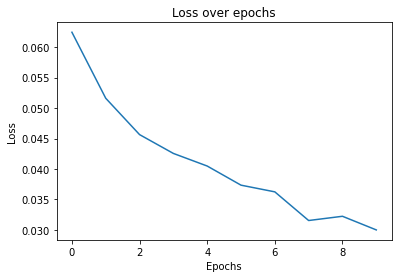

In [66]:
# Plot for loss over epochs 
plt.plot(train_losses)
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


## (1 pt) Show plot for accuracy over epochs.


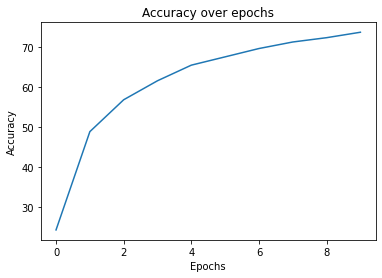

In [67]:
# Plot for accuracy over epochs
plt.plot(train_accuracy)
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


## (3 pt) Show confusion matrix on test data.

In [69]:
# Plot for confusion matrix using sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns

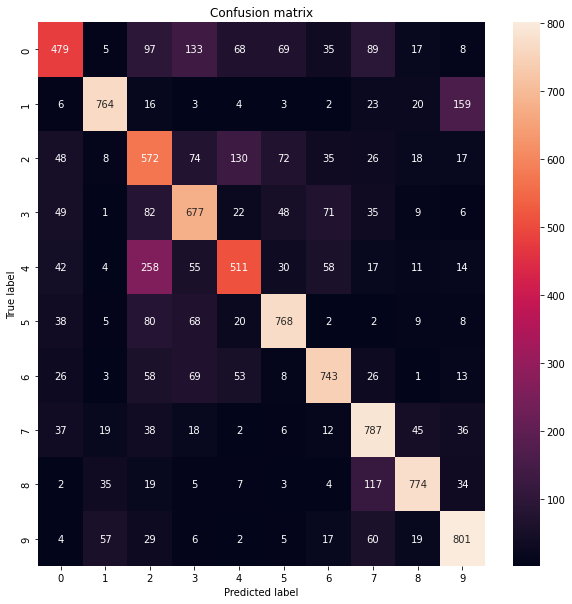

In [70]:
# get all predictions in an array and plot them as a confusion matrix
with torch.no_grad():
    n_classes = 10
    n_images = len(testloader.dataset)
    class_correct = list(0. for i in range(n_classes))
    class_total = list(0. for i in range(n_classes))
    y_true = []
    y_pred = []
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        c = (predictions == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            y_true.append(classes[label])
            y_pred.append(classes[predictions[i]])

cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()




## Extra Credits (5 pt)
Run VGG with pre-trained weights in this [colab](https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_vgg.ipynb#scrollTo=daily-wayne). Test any two images of your choice to your model and to VGG model and show accuracy (images must include objects from CIFAR10 classes). Discuss which model performs better and why.

# Part 3: Semantic Segmentation

## Overview
Semantic Segmentation is an image analysis task in which we classify each pixel in the image into a class.
So, let's say we have the following image.

![](https://lh3.googleusercontent.com/-ELUnFgFJqUU/XPPXOOmhfMI/AAAAAAAAAP0/2cabsTI9uGUYxM3O3w4EOxjR_iJvEQAvACK8BGAs/s374/index3.png)

And then given the above image its semantically segmentated image would be the following

![](https://lh3.googleusercontent.com/-gdUavPeOxdg/XPPXQngAnvI/AAAAAAAAAQA/yoksBterCGQGt-lv3aX4kfyMUDXTar7yACK8BGAs/s374/index4.png)

As you can see, that each pixel in the image is classified to its respective class.


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
import os 
import tarfile
import shutil
import urllib.request

url='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
path='VOC'
def get_archive(path,url):
  try:
    os.mkdir(path)
  except:
    path=path
  
  filename='devkit'
  urllib.request.urlretrieve(url,f"{path}/{filename}.tar")
 
get_archive(path,url)
def extract(path):
  tar_file=tarfile.open(f"{path}/devkit.tar")
  tar_file.extractall('./')
  tar_file.close()
  shutil.rmtree(path)

extract(path)

## Helper Functions

In [192]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torchvision.transforms as T
import numpy as np
import cv2

"""Various RGB palettes for coloring segmentation labels."""
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

if torch.cuda.is_available():
  device=torch.device('cuda:0')
  print('Cuda')
else:
  device=torch.device('cpu')
  print('cpu')

Cuda


## Code (25 pt)

### 1. Implement Data Loader for training and validation (5 pt)

In [193]:
import os 
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2

# You can modify this class 
class VocDataset(Dataset):
  def __init__(self, dir, color_map):
    self.root=os.path.join(dir,'VOCdevkit/VOC2007')
    self.target_dir=os.path.join(self.root,'SegmentationClass')
    self.images_dir=os.path.join(self.root,'JPEGImages')
    file_list = os.path.join(self.root,'ImageSets/Segmentation/trainval.txt')
    self.files = [line.rstrip() for line in tuple(open(file_list, "r"))]
    self.color_map=color_map

  def convert_to_segmentation_mask(self,mask):
    # This function converts color channels of semgentation masks to number of classes
    # Semantic Segmentation requires a segmentation mask to be a NumPy array with the shape
    # This part is implemented for displaying colorized results in subpart 3
    # YOUR CODE HERE:
    height, width = mask.shape[:2]
    segmentation_mask = np.zeros((height, width, len(self.color_map)), dtype=np.float32)
    for label_index, label in enumerate(self.color_map):
          segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
    return segmentation_mask

  def __getitem__(self,index):
    # YOUR CODE HERE:
    image_id=self.files[index]
    image_path=os.path.join(self.images_dir,f"{image_id}.jpg")
    label_path=os.path.join(self.target_dir,f"{image_id}.png")
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(256,256))
    image=torch.tensor(image).float()
    label=cv2.imread(label_path)
    label=cv2.cvtColor(label,cv2.COLOR_BGR2RGB)
    label=cv2.resize(label,(256,256))
    label = self.convert_to_segmentation_mask(label)
    label=torch.tensor(label).float()
    
    return image,label
    
  def __len__(self):
    return len(self.files)

# Load the dataset
dataset = VocDataset('',VOC_COLORMAP)
# Create a dataloader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

# Get a batch of training data
images, labels = next(iter(dataloader))
print(images.shape) # batch_size x 3 x 256 x 256
print(labels.shape) # batch_size x 21 x 256 x 256

dataset.__len__()


torch.Size([4, 256, 256, 3])
torch.Size([4, 256, 256, 21])


422

In [194]:
# Train set and validation set 
train_set,val_set=torch.utils.data.random_split(dataset,[int(len(dataset)*0.9),round(len(dataset)*0.1)+1])
train_loader = DataLoader(train_set, batch_size=10, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=10, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)

# print the length of train set and validation set
print(len(train_set))
print(len(val_set))



379
43


###2. Define model and training code (15 pt)
Implement FCN-32 model. You can use encoder as pretrained model provided by torchvision.       

In [195]:
import torch
class FCN32(torch.nn.Module):
  def __init__(self, n_classes, pretrained_model):
    # YOUR CODE HERE:
    super(FCN32, self).__init__()
    self.pretrained_model=pretrained_model
    # encoder
    self.encoder = torch.nn.Sequential(*list(pretrained_model.features.children()))

    self.encoder_classifier = torch.nn.Sequential(
        torch.nn.Conv2d(512, 4096, kernel_size=1),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(),
        torch.nn.Conv2d(4096, 4096, kernel_size=1),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout()
    )

    # decoder
    self.decoder = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(4096, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
        torch.nn.BatchNorm2d(512),
        torch.nn.ReLU(inplace=True),
        torch.nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(inplace=True),
        torch.nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(inplace=True),
        torch.nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(inplace=True),
        torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
        torch.nn.BatchNorm2d(32),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(32, n_classes, kernel_size=1)
    )

  # forward function
  def forward(self, x):
    # apply encoder
    output = self.encoder(x)
    output = self.encoder_classifier(output)

    # apply decoder
    output = self.decoder(output)

    # return the predicted label image
    return output


 Training code for the semantic segmentation model. Implment both training and validation parts.  

In [201]:
import torchvision 
from torch.utils.data import Dataset, DataLoader, random_split
import tqdm
import sklearn.metrics

def metrics(y_pred,y_true):
  y_pred=torch.argmax(y_pred,dim=1)
  y_true=torch.argmax(y_true,dim=1)
  iou=sklearn.metrics.jaccard_score(y_true.flatten(),y_pred.flatten(),average='weighted')
  return iou

def train(model,optim,loss_f,epochs,scheduler,path_for_models):
  try:
    os.mkdir(path_for_models)
  except:
    path_for_models=path_for_models

  min_iou=0.3
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


  for epoch in (range(epochs)):
    for (X_train,y_train) in train_loader:
      #X_train,y_train=X_train.to(device),y_train.to(device,dtype=torch.int64)
      X_train = X_train.permute(0, 3, 1, 2)
      y_train = y_train.permute(0, 3, 1, 2)
      y_pred=model(X_train)
      loss=loss_f(y_pred,y_train)
      optim.zero_grad()
      loss.backward()
      optim.step()
    ious=[]
    val_losses=[]
    with torch.no_grad():
      for b,(X_test,y_test) in enumerate(val_loader):
        #X_test,y_test=X_test.to(device),y_test.to(device)
        X_test = X_test.permute(0, 3, 1, 2)
        y_test = y_test.permute(0, 3, 1, 2)
        y_val=model(X_test)
        val_loss=loss_f(y_val,y_test)
        val_losses.append(val_loss)
        iou_= metrics(y_val,y_test)
        ious.append(iou_)
      ious=torch.tensor(ious)
      val_losses=torch.tensor(val_losses)
      scheduler.step(val_losses.mean())
      if ious.mean() > min_iou:
        min_iou=ious.mean()
        torch.save(model.state_dict(),f"{path_for_models}/fc32model.pth")
    print(f"epoch : {epoch:2} train_loss: {loss:10.4} , val_loss : {val_losses.mean()} val_iou: {ious.mean()}")


# YOUR CODE HERE:
# Load the pretrained model
pretrained_net = torchvision.models.vgg16(pretrained=True)

# Create the model
model = FCN32(n_classes=21, pretrained_model=pretrained_net)

# Define the loss function
criterion = torch.nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), learning_rate=0.0001)

# Define the learning rate scheduler
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=3,verbose=True)

# Define the number of epochs
num_epochs = 50

# Training
train(model,optimizer,criterion,50,scheduler,'models')

epoch :  0 train_loss:     0.6648 , val_loss : 0.6636990904808044 val_iou: 0.06645422412390647
epoch :  1 train_loss:     0.6364 , val_loss : 0.6362327337265015 val_iou: 0.08778575214069836
epoch :  2 train_loss:     0.6141 , val_loss : 0.6133363246917725 val_iou: 0.09312329576172612
epoch :  3 train_loss:     0.5907 , val_loss : 0.5913186073303223 val_iou: 0.09464990766848036
epoch :  4 train_loss:     0.5656 , val_loss : 0.5679311156272888 val_iou: 0.2324325057114301
epoch :  5 train_loss:     0.5409 , val_loss : 0.5452107787132263 val_iou: 0.41707641293873376
epoch :  6 train_loss:     0.5188 , val_loss : 0.5199036598205566 val_iou: 0.4579303562816353
epoch :  7 train_loss:      0.492 , val_loss : 0.4977358281612396 val_iou: 0.4847278200530288
epoch :  8 train_loss:     0.4763 , val_loss : 0.47471779584884644 val_iou: 0.5118984880514561
epoch :  9 train_loss:     0.4523 , val_loss : 0.45439058542251587 val_iou: 0.5209477738132241
epoch : 10 train_loss:     0.4322 , val_loss : 0.4368

In [202]:
model.load_state_dict(torch.load('./models/fc32model.pth'))

model.eval()

FCN32(
  (pretrained_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
   

### 3. Inference for semantic segmentation (5 pt)

Implement the inference code for semantic segmentation. Display the visualization results. Plot the image and colorized image (similar to the results in overview). 

/tmp/ipykernel_28229/3732159665.py:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread('./VOCdevkit/VOC2007/JPEGImages/000395.jpg'))


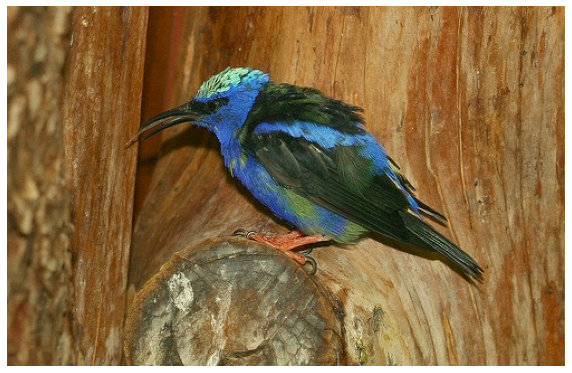

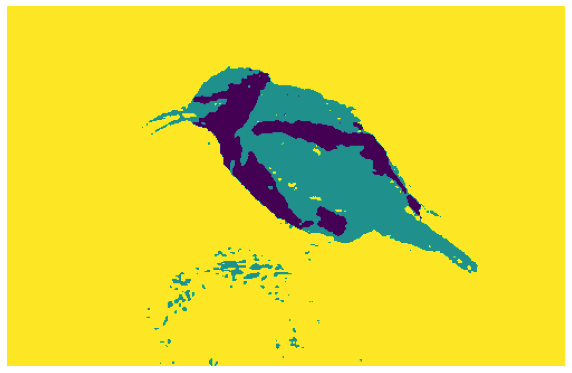

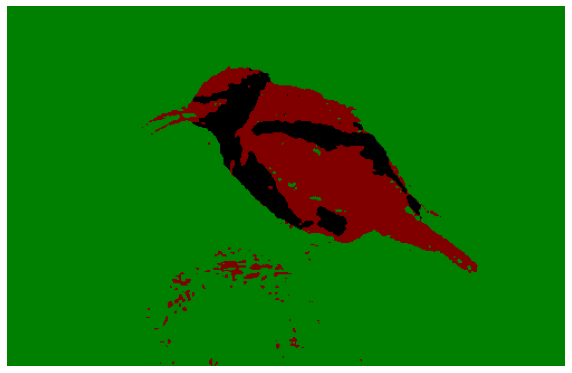

In [210]:
import imageio

# YOUR CODE HERE:

def decode_segmap(image,colors,nc=21):
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  # convert colors to list
  for l in range(0, nc):
    idx = image == l
    r[idx] = colors[l][0]
    g[idx] = colors[l][1]
    b[idx] = colors[l][2]
  rgb = np.stack([r, g, b], axis=2)
  return rgb
  
def image(img_path):
  img=cv2.imread(img_path,cv2.IMREAD_COLOR)
  img= torch.tensor(img)
  image = torch.argmax(img.squeeze(), dim=2).detach().cpu().numpy()
  plt.figure(figsize=(10, 10))
  plt.imshow(image)
  plt.axis('off')
  return image

# Plot original image 000395.jpg
plt.figure(figsize=(10, 10))
plt.imshow(imageio.imread('./VOCdevkit/VOC2007/JPEGImages/000395.jpg'))
plt.axis('off')
plt.show()

rgb = decode_segmap(image('./VOCdevkit/VOC2007/JPEGImages/000395.jpg'),VOC_COLORMAP)
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.axis('off')
plt.show()

## Write-up (5 pt)
* Describe the properties of segmentation model
* Describe the evaluation metric (IoU) for segmentation model 

### Describe the properties of segmentation model

Image segmentation is the process of dividing an image into multiple segments or regions, each of which corresponds to a different object or background. The FCN32 model is a type of convolutional neural network that is commonly used for image segmentation tasks.

- 1. One of the key properties of the FCN32 model is that it is fully convolutional, meaning that it contains only convolutional layers and does not have any fully connected layers. This allows the model to take train_features images of any size and produce corresponding segmentation maps of the same size.

- 2. Another important property of the FCN32 model is that it uses skip connections, which allow the model to retain spatial information from earlier layers in the network. This can help the model to make more fine-grained predictions and improve its overall accuracy.

- 3. Additionally, the FCN32 model uses a technique called upsampling to increase the resolution of the segmentation maps it produces. This allows the model to make more detailed predictions and produce segmentation maps with higher spatial resolution.

Overall, the FCN32 model is a powerful tool for image segmentation tasks, and its fully convolutional and upsampling properties make it well-suited for a variety of applications.

### Intersection-Over-Union [IOU] (Jaccard Index)

For good reason, the Intersection-Over-Union (IoU), also known as the Jaccard Index, is one of the most often employed metrics in semantic segmentation. The IoU is a relatively simple yet incredibly useful statistic. IoU is the predicted segmentation's area of overlap divided by the predicted segmentation's area of union divided by the predicted segmentation's area of union divided by the predicted segmentation's area of union divided by the predicted segmentation's area of union divided.

```
def metrics(y_pred,y_true):
  y_pred=torch.argmax(y_pred,dim=1)
  y_true=torch.argmax(y_true,dim=1)
  iou=sklearn.metrics.jaccard_score(y_true.flatten(),y_pred.flatten(),average='weighted')
  return iou
```
I have used jaccard score from sklearn on y_true and y_pred by flattening the data by weighted average. 

## Hint
* Refer to original paper FCNet : https://arxiv.org/abs/1411.4038
* Figures for FCNet Structure: https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1
* PyTorch Tutorial for Image semgnetation: https://towardsdatascience.com/train-neural-net-for-semantic-segmentation-with-pytorch-in-50-lines-of-code-830c71a6544f

# Part 4: Text2Img Generation (10 Points)

We have provided link to 'DALL.E' mini model to generate images from a text prompt in an interactive way.

https://colab.research.google.com/github/borisdayma/dalle-mini/blob/main/tools/inference/inference_pipeline.ipynb#scrollTo=118UKH5bWCGa

### Write-up (10 pts)
1. Try different prompts (as per your understanding) to reveal biases encoded by model (for example, birds always exist in the similar surroundings like trees).

2. By inputting creative text prompts, you should report the failure cases in your writeup i.e. when model doesn't quite understand the semantics of text prompt (for example, in case of long and complex sentences).

### Revealation of the biases encoded by the model

#### Promt 1:  A stoned monkey playing DJ in Amazon forest

The DALL.E mini model was able to encode the given promt. In the given promt, I was expecting Monkey, forest, DJ and facial expression of the monkey(stoned expression). The model was able to correctly encode and generate the images 

![image info](/home/sumedh/Desktop/CMSC_733_HW5/results/Dalli-e/1.png)

#### Promt 2:  Santa having vacation on planet Saturn with his family 

The DALL.E mini model was able to encode the given promt. In the given promt, I was expecting a santa, vaction environment, planet saturn and his family. The model was able to correctly encode and generate the images 

![image info](/home/sumedh/Desktop/CMSC_733_HW5/results/Dalli-e/2.png)

## Failure Cases

### Promt 1: Satilliete view of a bacteria on a planet which is 10 light years away
#### The DALL.E mini model failed to encode the given promt. In the given promt, I was expecting a image of bacteria. How so far the logic behind the promt, model should generate the bacteria image. But it failed to view show bacteria
![image info](/home/sumedh/Desktop/CMSC_733_HW5/results/Dalli-e/4.png)

### Promt 2: Microscopic view of Cosmic Cube from Iron man 2
#### The DALL.E mini model failed to encode the given promt. In the given promt, I was expecting a microscopic view but it gave me macroscopic view.
![image info](/home/sumedh/Desktop/CMSC_733_HW5/results/Dalli-e/3.png)

### Extra Credit (15 pts)

In this part, you would compare the results of two recent text-to-image generation models: DALL E (https://www.craiyon.com) v/s Stable Diffusion (https://huggingface.co/spaces/stabilityai/stable-diffusion). 

1. You can compare the results of two models in terms of: image quality, diversity of background, grounding in the text prompt and so on.

2. Similar to the main write-up, you are required to report 2 biases and 2 failure cases: i) where these models are unfairly biased, and ii) cases where one model is able to rectify the mistakes (of not understanding the semantics of text prompt) made by other one.



Note: You shouldn't copy/past examples from internet, and any event of exact matching for any of the text prompts would be penalized.

# 2 Biases:

## Promt 1: A glass turtle floating in space with oxygen

### The DALL.E mini model
 
#### Model was able to encode biases for the given promt unfairly but it was accurate to 70 percent. In the given promt, I was expecting a glass turtle, space, floating with oxygen visualization. The unfair bias here is that oxygen was missing and no proper visualization on whether turtle is glass or not

![image info](/home/sumedh/Desktop/CMSC_733_HW5/results/Dalli-e/5.png)


### Stable Diffusion
 
#### Model was able to encode biases for the given promt with atmost accuracy to 85 percent. In the given promt, I was expecting a glass turtle, space, floating with oxygen visualization. All the biases are visually presented, I can say there is a huge improvement in image clarity and biases in diffusion model. 

![image inf](/home/sumedh/Desktop/CMSC_733_HW5/results/Dalli-e/6.png)

## Promt 2: A man with beard watching a movie along with baby Yoda

### The DALL.E mini model
 
#### Model was able to encode biases for the given promt with atmost accuracy to 80 percent. In the given promt, I was expecting a man with beard, movie environment, baby yoda.  All the biases are visually presented but the clarity of the image is poor and blurry

![image info](/home/sumedh/Desktop/CMSC_733_HW5/results/Dalli-e/7.png)


### Stable Diffusion
 
#### Model was able to encode biases for the given promt unfairly but it was accurate to 60 percent. In the given promt, I was expecting  expecting a man with beard, movie environment, baby yoda. Not all the biases are visually presented, In few images there arent any humans and the movie environment was missing. I can say there is a huge improvement in image clarity and biases in diffusion model, but the biases encoded are poor when comapared with DALLIE. 

![image inf](/home/sumedh/Desktop/CMSC_733_HW5/results/Dalli-e/8.png)

# 2 Failure Cases

## Promt 1: Convert a triangle to a circle

### The DALL.E mini model
 
#### Model was unable to generate or encode the given prompt. In the given promt, I was expecting a new shape that doesnt have 3 corners. However, model was generting images with indvidual circles and triangles overlapped.

![image info](/home/sumedh/Desktop/CMSC_733_HW5/results/Dalli-e/9.png)


### Stable Diffusion
 
#### Model was unable to generate or encode the given prompt. In the given promt, I was expecting a new shape that doesnt have 3 corners. However, model was generting images with indvidual circles and triangles overlapped. However, the image clarity is good and pictures are more colorful

![image inf](/home/sumedh/Desktop/CMSC_733_HW5/results/Dalli-e/10.png)

## Promt 2: A human with multiple skin tones and genders

### The DALL.E mini model
 
#### Model was unable to generate or encode the given prompt. In the given promt, I was expecting a new kind of human being with different color tones like pink, orange or any other color with a different gender other than male, female and trans. Rather, it was generating images that are inclind toward more brown and multiple eyes. Dallie is comparitively better than diffusion as it was able to modify features of humans with different facial elements 

![image info](/home/sumedh/Desktop/CMSC_733_HW5/results/Dalli-e/11.png)


### Stable Diffusion
 
#### Model was unable to generate or encode the given prompt. In the given promt, I was expecting a new kind of human being with different color tones like pink, orange or any other color with a different gender other than male, female and trans. Model generate weired pitures of multiple humans in single image and a bunch of cartoon. Diffusion model was completely wrong in this case. 

![image inf](/home/sumedh/Desktop/CMSC_733_HW5/results/Dalli-e/12.png)